In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import scipy.signal as sps
import matplotlib.ticker as ticker
import pandas as pd
%matplotlib inline

In [2]:
ca1 = []
ca3 = []
for i in range(5):
    ca1.append(np.load("data/ca1_0_" + str(i) + ".npy"))
    ca3.append(np.load("data/ca3_0_" + str(i) + ".npy"))   
    
ca1 = np.array(ca1)
ca3 = np.array(ca3)

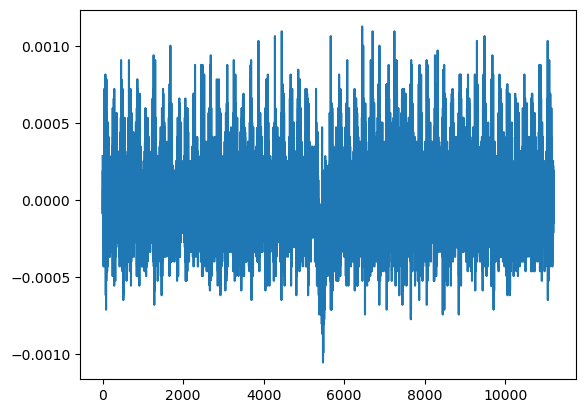

In [3]:
plt.plot(ca1[0])

In [5]:
ca1.mean(axis=0).shape

(11202,)

In [8]:
for j, vals in enumerate([(5, 100), (3, 200), (7, 300), (9, 400), (8, 500), (8, 1000)]):
    ca1_all = []
    ca3_all = []
    lens, val = vals
    for i in range(lens):
        ca1 = np.load("data/ca1_" + str(j) + "_" + str(i) + ".npy")
        ca3 = np.load("data/ca3_" + str(j) + "_" + str(i) + ".npy")
        
        ca1_all.append(ca1)
        ca3_all.append(ca3)
        
        np.savetxt("data/txtfiles/ca1_" + str(val) + "_" + str(i) + ".txt", ca1)
        np.savetxt("data/txtfiles/ca3_" + str(val) + "_" + str(i) + ".txt", ca3) 
        
    np.savetxt("data/txtfiles/ca1_" + str(val) + "_среднее.txt", np.array(ca1_all).mean(axis=0))
    np.savetxt("data/txtfiles/ca3_" + str(val) + "_среднее.txt", np.array(ca3_all).mean(axis=0)) 

In [ ]:
def gausFilter(signal, sigma = 35):
    min1 = np.min(signal)
    gf = gaussian_filter(signal, sigma)
    min2 = np.min(gf)
    return gf*min1/min2

In [ ]:
def getAnswer(signal):
    left = right = np.argmin(signal)
    mean = np.mean(signal)
    while signal[left]<mean and left>0:
        left-=1
    while signal[right]<mean and right<maxlen:
        right+=1
    return [left, right]

In [61]:
def FreqFiltering(signals, n_freq):
    freq = np.fft.rfft(signals, axis=1)

    r = np.abs(freq)
    a = np.angle(freq)
    r[:, n_freq:] = 0

    filt_freq = r * np.exp(1j*a)
    filtered_recs = np.fft.irfft(filt_freq, signals.shape[1], axis=1) 
    return filtered_recs

In [62]:
ca1 = FreqFiltering(ca1, 48)
ca3 = FreqFiltering(ca3, 48)

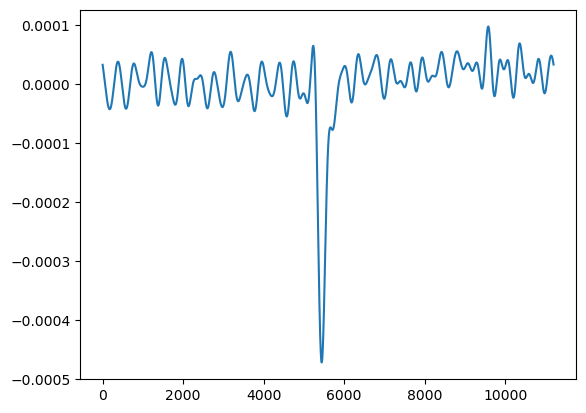

In [63]:
plt.plot(ca1[0])

In [71]:
train_ca1 = ca1[1:].copy()
test_ca1 = ca1[0].copy()

train_ca3 = ca3[1:].copy()
test_ca3 = ca3[0].copy()

for i in range(len(train_ca1)):
    train_ca1[i] = (train_ca1[i] - train_ca1[i].mean()) / train_ca1[i].std()
    train_ca3[i] = (train_ca3[i] - train_ca3[i].mean()) / train_ca3[i].std() 
    

test_ca1 = (test_ca1 - test_ca1.mean()) / test_ca1.std()
test_ca3 = (test_ca3 - test_ca3.mean()) / test_ca3.std()

In [82]:
batch_size = 64
train_window = 50

In [179]:
###Need to add hop


def create_inout_sequences(input_data, target_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in tqdm(range(0, L - batch_size, tw)):
        train_seq = input_data[i:i+tw]
        train_label = target_data[i:i+tw]
        inout_seq.append((torch.FloatTensor(train_seq), torch.FloatTensor(train_label)))
    return inout_seq

In [180]:
for idx, (x, y) in enumerate(tqdm(test_dataloader)):
    pass

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3003.08it/s]


In [181]:
train_inout_seq = []
for i in range(len(train_ca1)):
    train_inout_seq += create_inout_sequences(train_ca3[i], train_ca1[i], train_window)
    
test_inout_seq = create_inout_sequences(test_ca3, test_ca1, train_window)

100%|█████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 37160.50it/s]


In [182]:
train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [183]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, 
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(2*hidden_layer_size, output_size)


    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # layer 2
        x = self.dropout(lstm_out)
        predictions = self.linear_2(x)
        return predictions

In [184]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model_lstm = model_lstm.to('cuda')

In [185]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(tqdm(dataloader)):
        if is_training:
            optimizer.zero_grad()
        
        
        x = x[..., None].to('cuda')
        y = y[..., None].to('cuda')

        out = model(x)
        
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

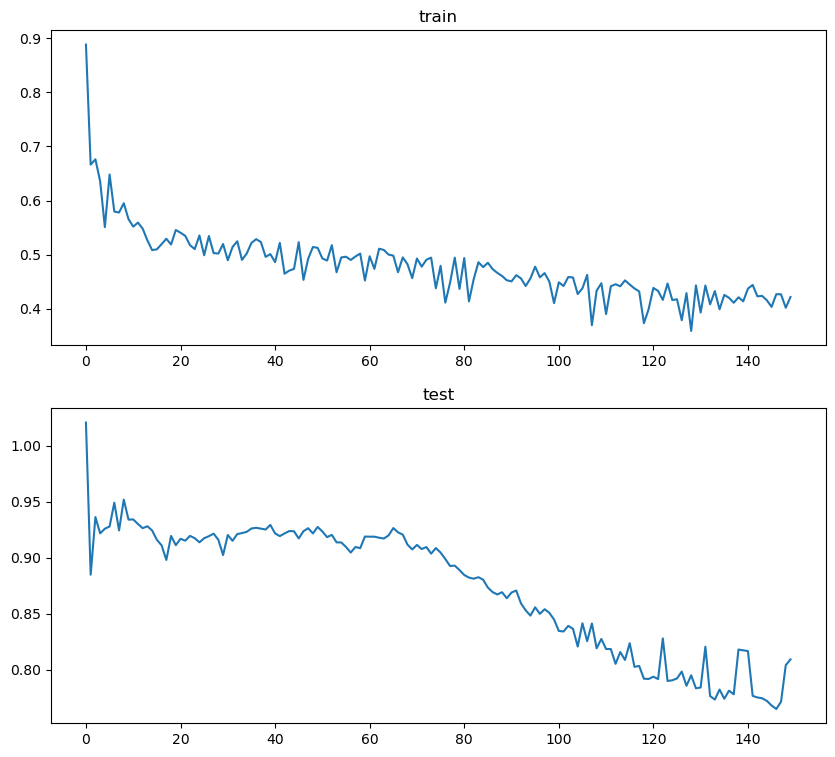

Epoch[150/150] | loss train:0.421706, test:0.809049


In [186]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 150

losses_train = []
losses_test = []
best_loss = 10e9

# begin training
for epoch in range(epochs):
    if epoch > 8:
      lr = 0.0001
    if epoch > 20:
      lr = 0.00005
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_lstm.state_dict(), "./LSTMCA1_CA3GOODPRED")

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))

    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [187]:
model_lstm.load_state_dict(torch.load("./LSTMCA1_CA3GOODPRED"))

<All keys matched successfully>

In [188]:
preds = []
model_lstm.eval()
for idx, (x, y) in enumerate(tqdm(test_dataloader)):
        
        
        x = x[..., None].to('cuda')
        

        out = model_lstm(x)
        
        preds.append(out.detach().cpu().numpy().flatten())
preds = np.array(preds)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.74it/s]


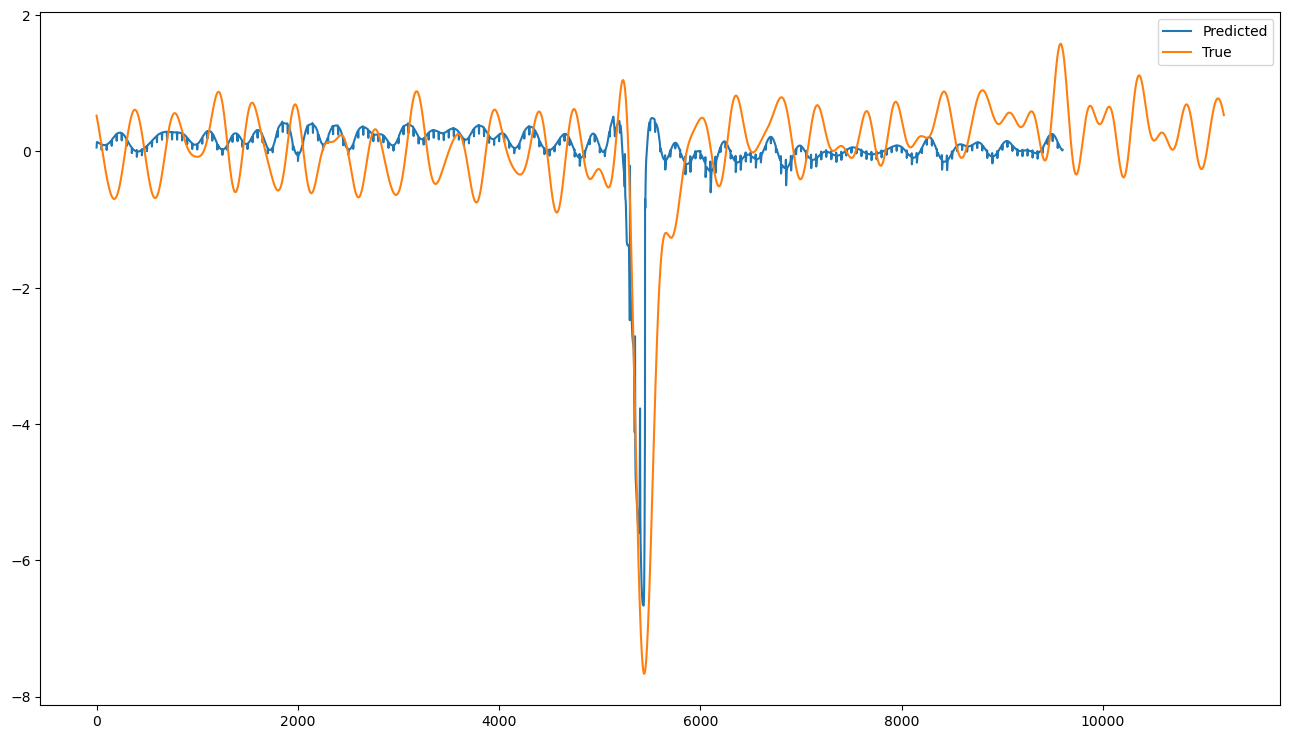

In [195]:
plt.figure(figsize=(16, 9))
plt.plot(preds.flatten(), label="Predicted")
plt.plot(test_ca1, label="True")
plt.legend()